In [1]:
import h5py
import pandas as pd
import numpy as np
np.random.seed(1)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use("ggplot")
%matplotlib inline

from __future__ import division
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
data = pd.read_csv("data/creditcard.csv")

### Data Review

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
data.Time[data.Class == 1].describe()

count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

In [7]:
data.Time[data.Class == 0].describe()

count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64

In [8]:
data.Class.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

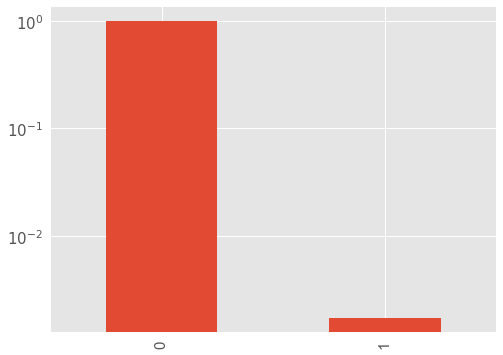

In [9]:
data.Class.value_counts(normalize=True).plot(kind="bar", logy=True, figsize=(8, 6), fontsize=15)
pass

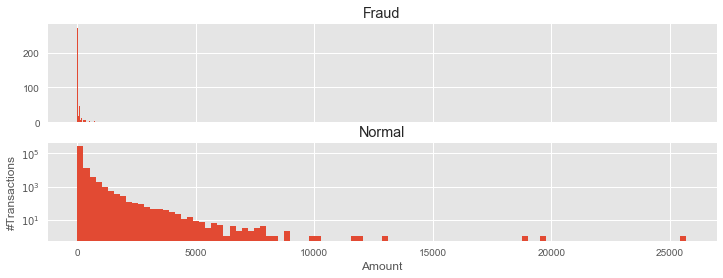

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 4))
data.Amount[data.Class == 1].hist(ax=ax1, bins=100)
data.Amount[data.Class == 0].hist(ax=ax2, bins=100, log=True)
ax1.set_title("Fraud")
ax2.set_title("Normal")
plt.xlabel("Amount")
plt.ylabel("#Transactions")
pass

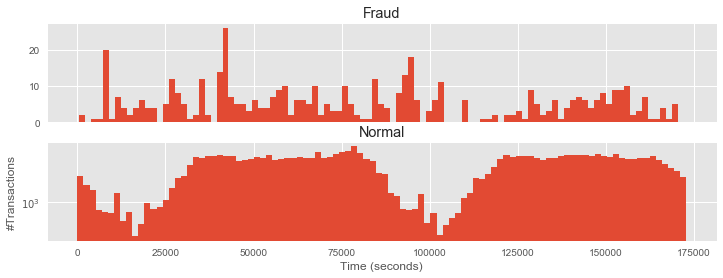

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
data.Time[data.Class == 1].hist(ax=ax1, bins=100)
data.Time[data.Class == 0].hist(ax=ax2, bins=100, log=True)
ax1.set_title("Fraud")
ax2.set_title("Normal")
plt.xlabel("Time (seconds)")
plt.ylabel("#Transactions")
pass

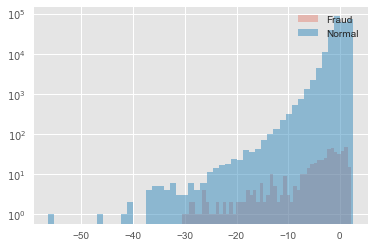

In [12]:
plt.hist(data.V1[data.Class == 1], 50, alpha=0.3, label="Fraud")
plt.hist(data.V1[data.Class == 0], 50, alpha=0.5, label="Normal", log=True)
plt.legend(loc='upper right')
pass

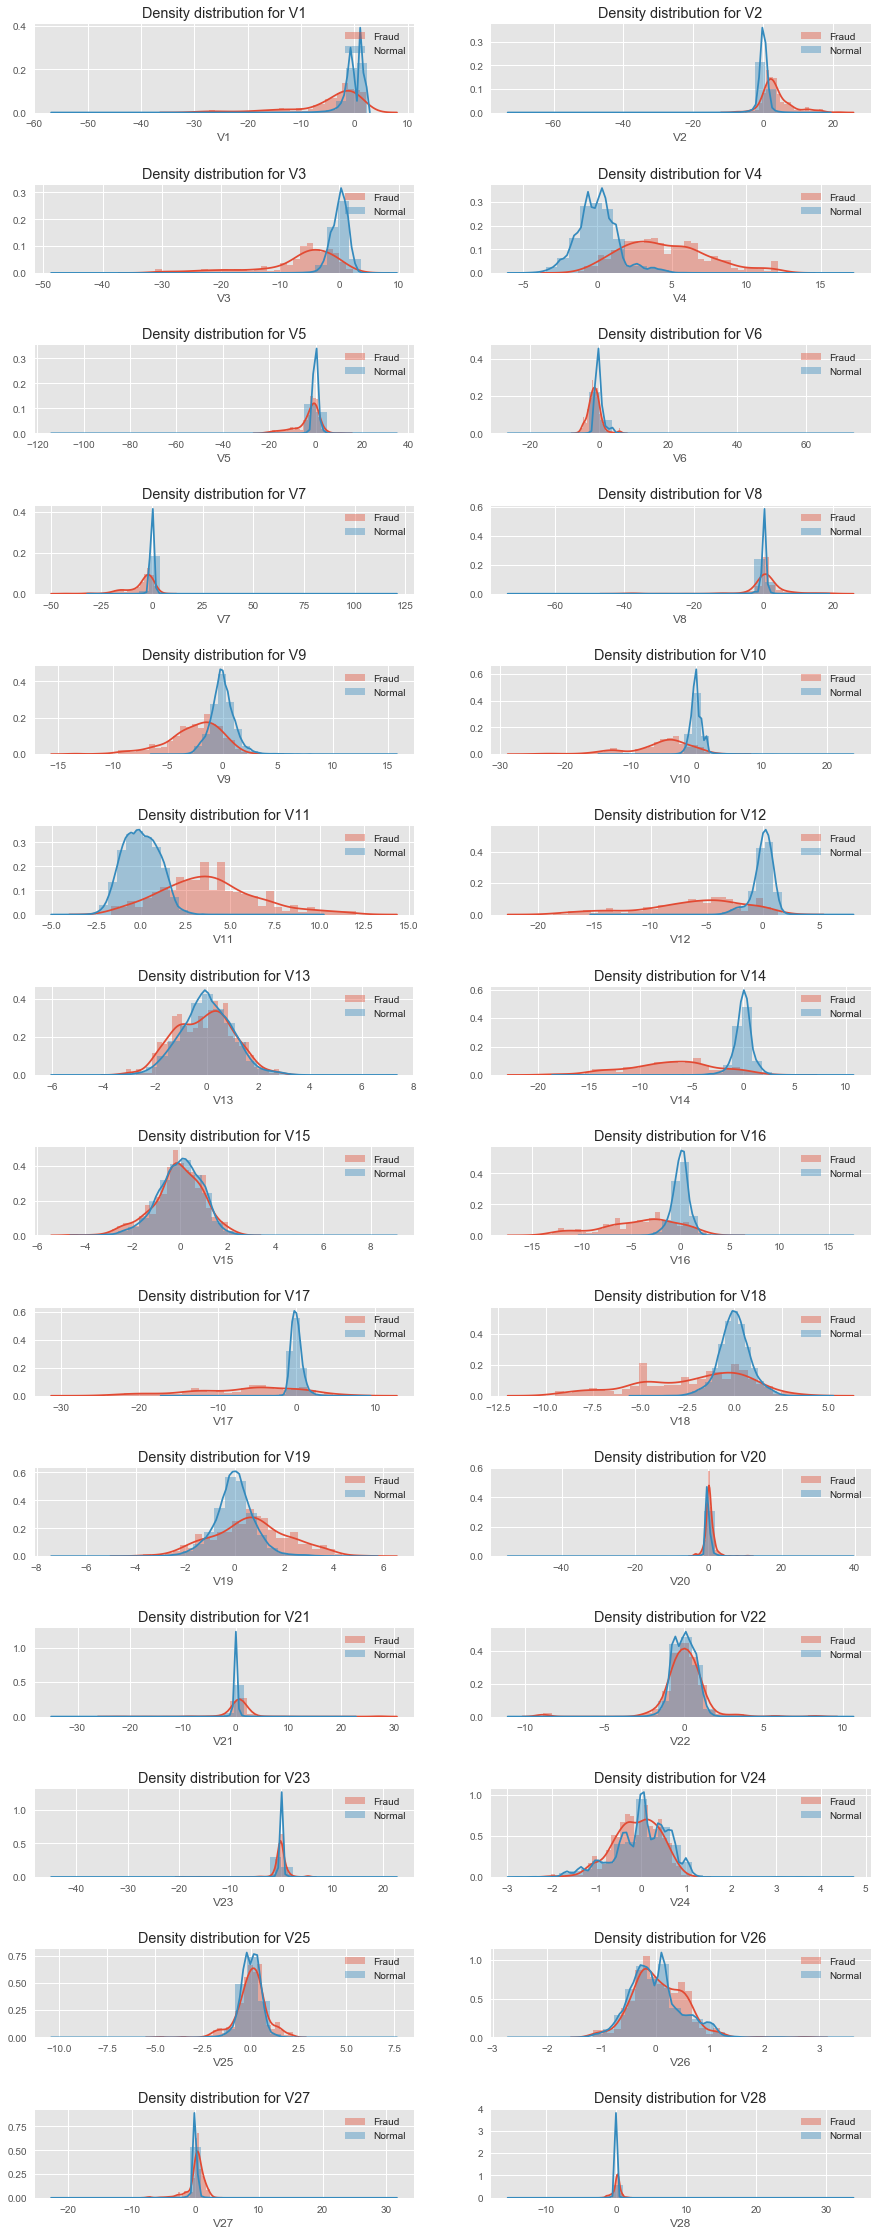

In [13]:
plt.figure(figsize=(15, 40))
gs = gridspec.GridSpec(14, 2, hspace=0.8)
bins = 30
for i, j in enumerate(data.columns[1:29]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[j][data.Class == 1], bins=bins, label="Fraud")
    sns.distplot(data[j][data.Class == 0], bins=bins, label="Normal")
    ax.set_title("Density distribution for {}".format(j))
    ax.legend(loc="upper right")
pass

### Modelling: Train and Cross-Validate a Neural Network

In [14]:
EPOCHS = 20
BATCH_SIZE = 32
PATIENCE = 4
N_SPLIT_SIZE = 10
V_SPLIT_NN = 0.2
T_SPLIT_RS = 0.2

In [15]:
def evaluation(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    return acc, prec, rec

In [16]:
def neural_network(data):
    model = Sequential()
    model.add(Dense(256, activation="sigmoid", input_dim=data.shape[1]))
    model.add(Dense(128, activation="sigmoid"))
    model.add(Dense(64, activation="sigmoid"))
    model.add(Dense(32, activation="sigmoid"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [17]:
def run(model, index, X_train, X_test, y_train, y_test):
    early_stopping = EarlyStopping(monitor="loss", patience=PATIENCE)
    model_callback = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                               validation_split=V_SPLIT_NN, callbacks=[early_stopping], verbose=1)
    model.save("models/model_{i}.h5".format(i=index))
    
    y_test_score = model.predict(X_test)
    y_test_pred = model.predict_classes(X_test)
    acc, prec, rec = evaluation(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_test_score)
    return acc, prec, rec, auc, model_callback.history["loss"], model_callback.history["val_loss"]

#### Oversample

In [18]:
# Oversample
sm = SMOTE(random_state=0)
X, y = data[data.columns[1:29]].values, data.Class.values
X_res, y_res = sm.fit_sample(X, y)

In [19]:
pd.Series(y_res).value_counts()

1    284315
0    284315
dtype: int64

In [20]:
nn = neural_network(X_res)

In [21]:
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               7424      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 50,689
Trainable params: 50,689
Non-trainable params: 0
_________________________________________________________________


In [22]:
skf = StratifiedKFold(n_splits=N_SPLIT_SIZE, random_state=0)

results = []
for index, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    clear_output()
    print("Run iteration: {i}".format(i=index))
    X_train, X_test = X_res[train_index], X_res[test_index]
    y_train, y_test = y_res[train_index], y_res[test_index]
    results.append(run(neural_network(X_train), index, X_train, X_test, y_train, y_test))

Run iteration: 9
Train on 409414 samples, validate on 102354 samples
Epoch 1/20
409414/409414 [==============================] - 33s - loss: 0.0910 - acc: 0.9659 - val_loss: 0.0569 - val_acc: 0.9813
Epoch 2/20
409414/409414 [==============================] - 33s - loss: 0.0335 - acc: 0.9885 - val_loss: 0.0103 - val_acc: 0.9975
Epoch 3/20
409414/409414 [==============================] - 31s - loss: 0.0205 - acc: 0.9945 - val_loss: 0.0029 - val_acc: 0.9987
Epoch 4/20
409414/409414 [==============================] - 36s - loss: 0.0163 - acc: 0.9960 - val_loss: 0.0230 - val_acc: 0.9907
Epoch 5/20
409414/409414 [==============================] - 34s - loss: 0.0147 - acc: 0.9964 - val_loss: 0.0021 - val_acc: 0.9993
Epoch 6/20
409414/409414 [==============================] - 36s - loss: 0.0141 - acc: 0.9968 - val_loss: 1.4299e-05 - val_acc: 1.0000
Epoch 7/20
409414/409414 [==============================] - 35s - loss: 0.0138 - acc: 0.9971 - val_loss: 9.4838e-04 - val_acc: 0.9996
Epoch 8/20
40

In [38]:
metrics = [i[0:4] for i in results]
metrics_df = pd.DataFrame(metrics, columns=["Accuracy", "Precision", "Recall", "AUC"])

In [24]:
# take average of n runs
metrics_df.mean()

Accuracy     0.998393
Precision    0.997174
Recall       0.999620
AUC          0.999457
dtype: float64

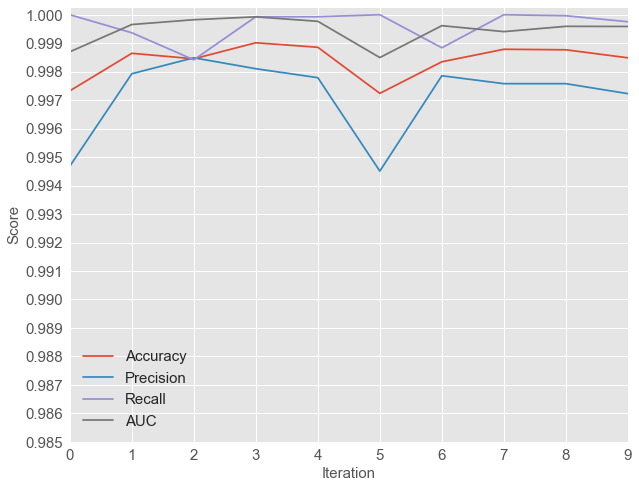

In [52]:
metrics_df.plot(figsize=(10, 8), fontsize=15, yticks=np.arange(0.985, 1, 0.001))
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Score", fontsize=15)
plt.legend(loc="lower left", fontsize=15)
pass

In [26]:
# save it to csv
pd.DataFrame(results).to_csv("result.csv", header=False)

#### Loss

In [27]:
# training loss
loss_list = []
for i in range(len(results)):
    loss_list.append(pd.Series([j[4] for j in results][i]))

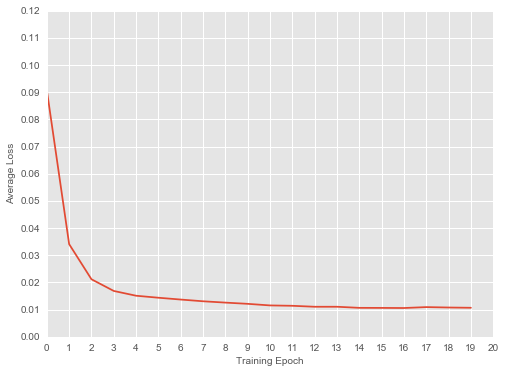

In [28]:
pd.concat(loss_list, axis=1).mean(axis=1).plot(xlim=[0, 20], xticks=range(21), yticks=np.arange(0, 0.13, 0.01), 
                                               figsize=(8, 6), fontsize=10)
plt.xlabel("Training Epoch", fontsize=10)
plt.ylabel("Average Loss", fontsize=10)
pass

In [29]:
# validation loss
loss_list = []
for i in range(len(results)):
    loss_list.append(pd.Series([j[5] for j in results][i]))

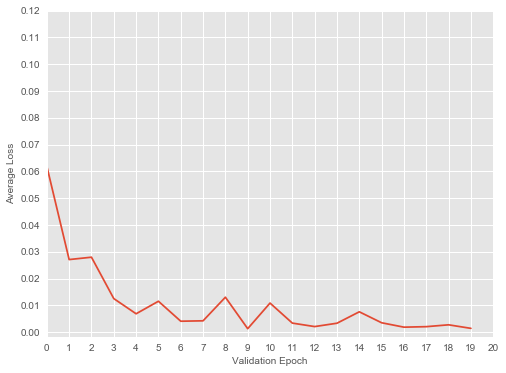

In [30]:
pd.concat(loss_list, axis=1).mean(axis=1).plot(xlim=[0, 20], xticks=range(21), yticks=np.arange(0, 0.13,0.01),
                                              figsize=(8, 6), fontsize=10)
plt.xlabel("Validation Epoch", fontsize=10)
plt.ylabel("Average Loss", fontsize=10)
pass

In [31]:
# training and validation loss
train_loss = []
val_loss = []
for i in range(len(results)):
    train_loss.append(pd.Series([j[4] for j in results][i]))
    val_loss.append(pd.Series([j[5] for j in results][i]))

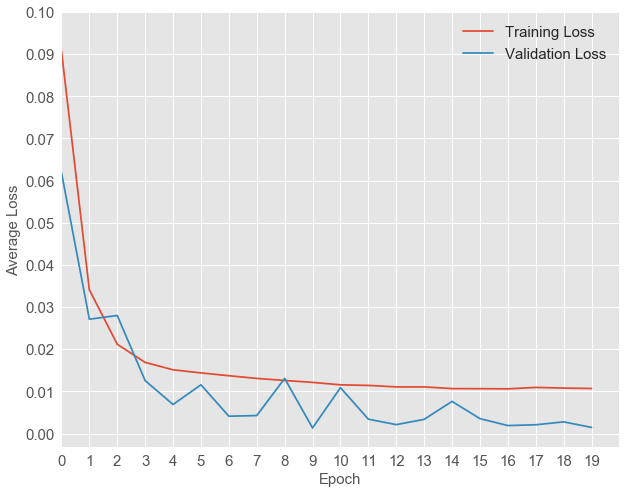

In [32]:
train_loss_avg = pd.concat(train_loss, axis=1).mean(axis=1)
val_loss_avg = pd.concat(val_loss, axis=1).mean(axis=1)

train_and_val_loss = pd.concat([train_loss_avg, val_loss_avg], axis=1)
train_and_val_loss.rename(index=str, columns={0: "Training Loss", 1: "Validation Loss"}) \
                  .plot(xlim=[0, 20], xticks=range(21), yticks=np.arange(0, 0.11,0.01), 
                        figsize=(10, 8), fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Average Loss", fontsize=15)
plt.legend(loc="upper right", fontsize=15)
pass

### Load Best Model

In [33]:
metrics_df

,Accuracy,Precision,Recall,AUC
0,0.997327,0.994682,1.000000,0.998699
1,0.998646,0.997928,0.999367,0.999656
2,0.998452,0.998488,0.998417,0.999825
3,0.999015,0.998104,0.999930,0.999926
4,0.998857,0.997789,0.999930,0.999769
5,0.997239,0.994508,1.000000,0.998496
6,0.998347,0.997857,0.998839,0.999616
7,0.998787,0.997579,1.000000,0.999407
8,0.998769,0.997579,0.999965,0.999592
9,0.998488,0.997228,0.999754,0.999588


In [34]:
# Recall
np.argmax(np.array(metrics)[:,2])

0

In [35]:
model = load_model("models/model_0.h5")

In [36]:
y_pred = model.predict_classes(X)

283584/284807 [============================>.] - ETA: 0s

In [37]:
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
print(acc, prec, rec)

(0.99779850916585622, 0.43967828418230565, 1.0)
